# Attention on MNIST (Saliency and grad-CAM)

https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb

https://raghakot.github.io/keras-vis/visualizations/saliency/

In [1]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 9s 152us/step - loss: 0.2380 - acc: 0.9280 - val_loss: 0.0527 - val_acc: 0.9833
Epoch 2/2
59776/60000 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9751Test loss: 0.037809986026689876
Test accuracy: 0.987


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Saliency

In [3]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    # [3,4] after normalize => [3/5,4/5]

    # K.epsilon()) = 10^-7, prevent from dividing by zero
    
    return x / ( K.sqrt(K.mean(K.square(x))) + K.epsilon() )


index_category 4
loss_value [0.9999995]
grads_value [[[[-6.80108846e-04]
   [ 3.60229955e-04]
   [ 7.33201997e-03]
   [-2.17790902e-02]
   [-1.65388174e-02]
   [-5.24025187e-02]
   [-3.35664190e-02]
   [ 1.80713995e-03]
   [ 9.45589971e-03]
   [ 4.55212221e-02]
   [ 3.63995247e-02]
   [ 4.10107779e-04]
   [-6.29282731e-04]
   [-1.39855770e-02]
   [-1.70503315e-02]
   [-2.44681332e-02]
   [-3.50867249e-02]
   [-2.23536268e-02]
   [-1.77255832e-02]
   [ 8.29786470e-04]
   [ 3.87310982e-02]
   [ 2.61764061e-02]
   [-5.83268292e-02]
   [-3.37286890e-02]
   [ 4.26494293e-02]
   [ 3.33169848e-02]
   [ 2.92587746e-03]
   [ 0.00000000e+00]]

  [[-4.02565238e-05]
   [ 2.17944365e-02]
   [ 4.96169329e-02]
   [ 3.04579977e-02]
   [ 6.21057255e-03]
   [-2.52775643e-02]
   [-7.71443769e-02]
   [-6.01277985e-02]
   [-4.37154882e-02]
   [ 2.51008328e-02]
   [ 7.50752240e-02]
   [ 6.51061386e-02]
   [ 2.54222192e-02]
   [-3.07056513e-02]
   [-3.66143323e-02]
   [-5.24771735e-02]
   [-6.75725639e-02]
 

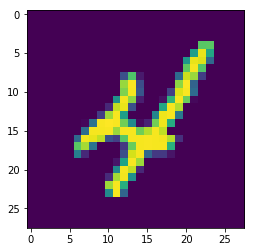

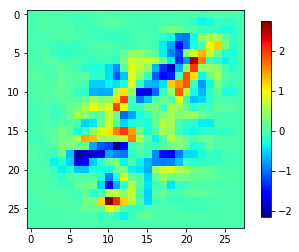

In [6]:
import matplotlib.pyplot as plt

index_image = 9
input_img_data = x_train[index_image].reshape(1,28,28,1)
predict_vector = model.predict(input_img_data)
index_category = np.argmax(predict_vector)
# print(predict_vector)
# print(index_category)
plt.imshow(input_img_data[0,:,:,0])

input_img = model.input

layer_output = model.layers[-1].output
# loss = K.mean(layer_output[:,index_category])
loss = layer_output[:,index_category]

grads = K.gradients(loss, [input_img])[0]
grads = normalize(grads)

fn = K.function([input_img], [loss,grads,layer_output])


loss_value, grads_value, layer_output = fn([input_img_data])

print('index_category',index_category)
print('loss_value',loss_value)
print('grads_value',grads_value)
print('layer_output',layer_output)

plt.imshow(x_train[index_image,:,:,0])
plt.show()
sc = plt.imshow(grads_value[0,:,:,0],cmap = 'jet')
cbar = plt.colorbar(sc, shrink = .9)
plt.show()